# Generate a homodimer test set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
#### boilerplate

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import dataclass, field

import numpy as np
import pandas as pd
from dataclass_wizard import JSONWizard

Mess around with paths because I'm running this a few times on different systems.

In [2]:
!which python
!pwd

/home/k/kaindll/mambaforge/envs/ppi/bin/python
/home/k/kaindll


In [3]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/data/ppi_dataset/template')
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)
package_root

'/home/k/kaindll/ppi'

In [4]:
session = '7082'
session_dir = cwd.parent / 'results' / session

assert session_dir.is_dir(), 'use on a previously generated dataset!'
os.chdir(session_dir.resolve())
!pwd

/home/k/kaindll/ppi/data/ppi_dataset/results/7082


In [5]:
from ppi_utils.cfg import Config, SamplingStrategy
from ppi_utils import api, extract, general, pairs, plot, reduce, proteome

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

#### config
These are the somewhat relevant settings. Have a look!

In [6]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    seed: int = 42
    ratio: float = 4.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

val_species = set()
# {237561, 37296, 9031, 8355, 9913, 7955, 39947, 10116, 36329, 224308}
train_species = set()  # select only this subset
params = Params()

The detour below is meant to keep the class definition above short, and the `Config` class importable from other modules.

In [7]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config, val_species=val_species, train_species=train_species,
        cwd=session_dir, strategy=params.strategy
    ))

#### importlib
For development, it's nice to be able to edit the imported modules.

In [8]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

In [9]:
# maybe fix this!
c.pp = c.dp / 'proteomes'
c.pp.mkdir(parents=True, exist_ok=True)
c.pp

PosixPath('homodimers/proteomes')

#### Create homodimer set
#### APID

In [10]:
ppis = extract_apid_ppis(c.qp)
assert len(ppis) == 161598

In [11]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
assert len(hash_ppis) == 160568

In [12]:
sp_lookup = ppis_to_sp_lookup(hash_ppis)

In [13]:
hash_ppis = hash_ppis.loc[hash_ppis.hash_A == hash_ppis.hash_B].copy()
hash_ppis

,hash_A,hash_B,species
6394,CRC-000D39D2EDD7E4E7,CRC-000D39D2EDD7E4E7,3702
1250,CRC-003617E73298544F,CRC-003617E73298544F,3702
4867,CRC-00455F120CB9C22A,CRC-00455F120CB9C22A,6239
18261,CRC-004EA3E702332905,CRC-004EA3E702332905,559292
18275,CRC-004EB2E702222905,CRC-004EB2E702222905,559292
...,...,...,...
18251,CRC-FF934DE2F5145C40,CRC-FF934DE2F5145C40,559292
39372,CRC-FFBCCA1474839B88,CRC-FFBCCA1474839B88,3702
529,CRC-FFCDDDB266F2A3DB,CRC-FFCDDDB266F2A3DB,224308
42406,CRC-FFD7E9C734D89D19,CRC-FFD7E9C734D89D19,3702


In [14]:
apid_seqs = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(apid_seqs)

44707

dropped 104/4353 PPIs from length filtering
dropped 0/4248 table IDs and 0/4249 rows, and 40459/44707 sequence IDs


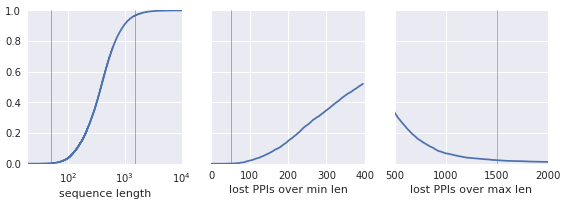

In [15]:
hash_ppis, hash_seqs, _ = filter_ppis_and_fasta_by_len(
    hash_ppis, apid_seqs, c.min_seq_len, c.max_seq_len)

In [16]:
len(hash_seqs), len(np.unique(hash_ppis.iloc[:, [0, 1]])), len(apid_seqs)

(4248, 4248, 44707)

#### HuRI

In [17]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
assert len(huri_ppis) == 97888

In [18]:
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
assert len(huri_hash_ppis) == 62559

In [19]:
sp_lookup.update(ppis_to_sp_lookup(huri_hash_ppis))

In [20]:
huri_hash_ppis = huri_hash_ppis.loc[huri_hash_ppis.hash_A
                                    == huri_hash_ppis.hash_B].copy()
huri_hash_ppis

,hash_A,hash_B,species
52871,CRC-002993EA6B0E4546,CRC-002993EA6B0E4546,9606
8496,CRC-003246D7C1D16723,CRC-003246D7C1D16723,9606
37350,CRC-00E417623E5287C6,CRC-00E417623E5287C6,9606
9995,CRC-02B583414DD59C20,CRC-02B583414DD59C20,9606
68825,CRC-02B5B13429A59CAA,CRC-02B5B13429A59CAA,9606
...,...,...,...
10819,CRC-FEE7DA7A6E02B08E,CRC-FEE7DA7A6E02B08E,9606
11693,CRC-FEF75640A29CCF56,CRC-FEF75640A29CCF56,9606
7555,CRC-FF13DDD5EBE47754,CRC-FF13DDD5EBE47754,9606
6618,CRC-FF37329A50FFB4E7,CRC-FF37329A50FFB4E7,9606


In [21]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.hash.fasta and huri/huri.json


9119

dropped 4/758 PPIs from length filtering
dropped 0/754 table IDs and 0/754 rows, and 8365/9119 sequence IDs


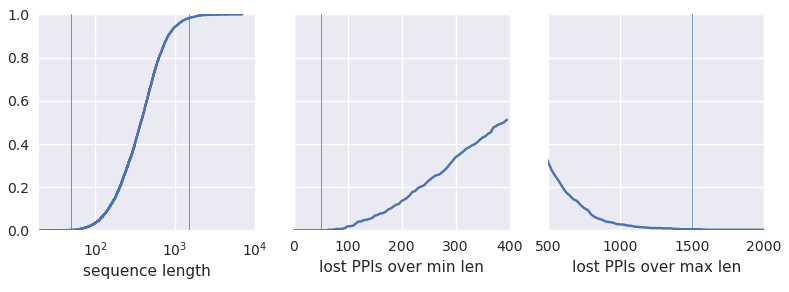

In [22]:
huri_hash_ppis, huri_hash_seqs, _ = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)

In [23]:
len(huri_hash_seqs), len(np.unique(huri_hash_ppis.iloc[:, [0, 1]])), len(huri_seqs)

(754, 754, 9119)

#### merge APID and HuRI

In [24]:
hash_ppis['source'] = 'apid'
huri_hash_ppis['source'] = 'huri'
hash_hds = pd.concat((hash_ppis, huri_hash_ppis)).drop(
    ['minlen', 'maxlen'], axis=1, errors='ignore')
hash_hds

,hash_A,hash_B,species,source
6394,CRC-000D39D2EDD7E4E7,CRC-000D39D2EDD7E4E7,3702,apid
1250,CRC-003617E73298544F,CRC-003617E73298544F,3702,apid
4867,CRC-00455F120CB9C22A,CRC-00455F120CB9C22A,6239,apid
18261,CRC-004EA3E702332905,CRC-004EA3E702332905,559292,apid
18275,CRC-004EB2E702222905,CRC-004EB2E702222905,559292,apid
...,...,...,...,...
10819,CRC-FEE7DA7A6E02B08E,CRC-FEE7DA7A6E02B08E,9606,huri
11693,CRC-FEF75640A29CCF56,CRC-FEF75640A29CCF56,9606,huri
7555,CRC-FF13DDD5EBE47754,CRC-FF13DDD5EBE47754,9606,huri
6618,CRC-FF37329A50FFB4E7,CRC-FF37329A50FFB4E7,9606,huri


In [25]:
hash_hds.species.value_counts()

559292     963
3702       781
9606       754
7227       416
284812     409
6239       393
83333      355
192222     204
10090      190
85962      134
1111708    118
224308      91
10116       59
36329       40
243276      22
237561      18
39947       12
9913         9
7955         9
10299        4
2697049      4
11706        3
9031         3
8355         3
1392         2
9986         2
10377        2
868565       1
632          1
333760       1
Name: species, dtype: int64

#### save

In [26]:
hds_seqs = {**hash_seqs, **huri_hash_seqs}
len(hds_seqs)

5001

In [26]:
c.hd_raw_fasta.parent.mkdir(parents=True, exist_ok=True)
_ = SeqIO.write(hds_seqs.values(), c.hd_raw_fasta, 'fasta')
hash_hds.to_csv(c.hd_raw_tsv, sep='\t', header=True, index=False)
c.hd_raw_fasta, c.hd_raw_tsv

(PosixPath('homodimers/homodimer_raw.fasta'),
 PosixPath('homodimers/homodimer_raw.tsv'))

#### cluster

In [26]:
# cluster against val
run_uniqueprot2D(c.hd_raw_fasta, c.val_fasta, c.hd_nr_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json homodimers/homodimer_raw.fasta apid_validation.fasta homodimers/homodimer_nr_val.fasta
using temporary directory homodimers/homodimer_rawp60glgbq
extract hvals from alignments: 100%|██████████| 3/3 [00:00<00:00, 12.19it/s]
 4095/5001::4357 non-redundant in homodimers/homodimer_raw.fasta against apid_validation.fasta written to homodimers/homodimer_nr_val.fasta


In [29]:
# red-reduce
run_uniqueprot(c.hd_nr_fasta, c.hd_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json homodimers/homodimer_nr_val.fasta homodimers/homodimer_rr_val.fasta
using temporary directory homodimers/homodimer_nr_valk5xvqtvh
extract hvals from alignments: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
 3172/4095 non-redundant in homodimers/homodimer_nr_val.fasta written to homodimers/homodimer_rr_val.fasta


In [27]:
# shrink
shrink_files_both_ways(c.hd_raw_tsv, c.hd_rr_fasta, c.hd_rr_tsv, c.hd_rr_fasta)

dropped 1829/5001 table IDs and 1831/5003 rows, and 0/3172 sequence IDs


In [27]:
hds = pd.read_csv(c.hd_rr_tsv, sep='\t', header=0)
hds

,hash_A,hash_B,species,source
0,CRC-000D39D2EDD7E4E7,CRC-000D39D2EDD7E4E7,3702,apid
1,CRC-00455F120CB9C22A,CRC-00455F120CB9C22A,6239,apid
2,CRC-006DFCDDBFFAE2E9,CRC-006DFCDDBFFAE2E9,559292,apid
3,CRC-0071930DED7F41B0,CRC-0071930DED7F41B0,3702,apid
4,CRC-0075E3A61B1CDE16,CRC-0075E3A61B1CDE16,3702,apid
...,...,...,...,...
3167,CRC-FC0EBA9B05FE9E62,CRC-FC0EBA9B05FE9E62,9606,huri
3168,CRC-FC6CFB2250AA4FC9,CRC-FC6CFB2250AA4FC9,9606,huri
3169,CRC-FC8F5BAE74A1FF55,CRC-FC8F5BAE74A1FF55,9606,huri
3170,CRC-FCBB6B328EF4D515,CRC-FCBB6B328EF4D515,9606,huri


In [28]:
c.test_species = {int(i) for i in hds.species.unique()}
hds.species.value_counts()

559292     735
3702       416
9606       392
284812     303
7227       270
6239       265
83333      259
192222     128
85962      112
10090      108
1111708    102
243276      19
10116       18
237561       9
36329        8
10299        4
2697049      4
7955         4
224308       3
1392         2
11706        2
9913         2
10377        1
632          1
8355         1
9986         1
9031         1
333760       1
39947        1
Name: species, dtype: int64

#### prep extra negative candidates
From APID and HuRI, extract sets of proteins that are not homodimers. Run it through the redundancy-reduction pipepline.

In [32]:
# filter out homodimers and sequences of wrong length from all proteins in our dataset
non_hd_seqs = {k: v for k, v in {**huri_seqs, **apid_seqs}.items()
               if k not in hds_seqs.keys() and c.min_seq_len <= len(v) <= c.max_seq_len}
len(non_hd_seqs)

46856

In [32]:
# write all the non-homodimer proteins to a single FASTA
_ = SeqIO.write(non_hd_seqs.values(), c.pp / 'proteins_raw.fasta', 'fasta')

In [56]:
# cluster against val
run_uniqueprot2D(c.pp / 'proteins_raw.fasta',
                 c.val_fasta, c.pp / 'proteins_nr_val.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json homodimers/proteomes/proteins_raw.fasta apid_validation.fasta homodimers/proteomes/proteins_nr_val.fasta
using temporary directory homodimers/proteomes/proteins_raw3eg614oh
extract hvals from alignments: 100%|██████████| 19/19 [00:02<00:00,  8.65it/s]
 39065/46856::4357 non-redundant in homodimers/proteomes/proteins_raw.fasta against apid_validation.fasta written to homodimers/proteomes/proteins_nr_val.fasta


In [57]:
# cluster against the positives
run_uniqueprot2D(c.pp / 'proteins_nr_val.fasta', c.hd_rr_fasta,
                 c.pp / 'proteins_nr_val_hds.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json homodimers/proteomes/proteins_nr_val.fasta homodimers/homodimer_rr_val.fasta homodimers/proteomes/proteins_nr_val_hds.fasta
using temporary directory homodimers/proteomes/proteins_nr_val_8r61q49
extract hvals from alignments: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]
 34114/39065::3172 non-redundant in homodimers/proteomes/proteins_nr_val.fasta against homodimers/homodimer_rr_val.fasta written to homodimers/proteomes/proteins_nr_val_hds.fasta


In [87]:
# red-reduce
run_uniqueprot(c.pp / 'proteins_nr_val_hds.fasta',
               c.pp / 'proteins_rr_val_hds.fasta',
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json homodimers/proteomes/proteins_nr_val_hds.fasta homodimers/proteomes/proteins_rr_val_hds.fasta
using temporary directory homodimers/proteomes/proteins_nr_val_hdsi3ozxnsp
extract hvals from alignments: 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]
 22747/34114 non-redundant in homodimers/proteomes/proteins_nr_val_hds.fasta written to homodimers/proteomes/proteins_rr_val_hds.fasta


In [41]:
# read the proteins back to memory, divy up by species
hds_proteome = {int(sp): dict() for sp in hds.species.unique()}
for _id, seqrecord in SeqIO.to_dict(SeqIO.parse(c.pp / 'proteins_rr_val_hds.fasta', 'fasta')).items():
    sp = sp_lookup[_id]
    if sp not in hds_proteome:
        continue
    hds_proteome[sp][_id] = {'seq': str(seqrecord.seq),
                             'source': 'apid' if sp != 9606 else 'huri',
                             'id': _id}
# dump immediately
_ = write_json(hds_proteome, c.pp / 'apid_huri_proteome.json')

In [36]:
# make a comparative table to see how many homodimer negatives could be generated from APID/HuRI
hds['label'] = 1
counts = (pd.DataFrame(hds.species.value_counts()).reset_index()
          .rename(columns=dict(index='species', species='n_hds'))
          .sort_values(by='species'))
counts['n_extras'] = counts.species.apply(lambda sp: len(hds_proteome[sp]))
counts['scale'] = round(counts.n_extras / counts.n_hds, 2)
counts

,species,n_hds,n_extras,scale
23,632,1,6,6.00
19,1392,2,2,1.00
1,3702,416,3230,7.76
5,6239,265,2644,9.98
4,7227,270,3768,13.96
17,7955,4,11,2.75
24,8355,1,3,3.00
26,9031,1,0,0.00
2,9606,392,4360,11.12
21,9913,2,3,1.50


In [37]:
counts.loc[counts.scale < 4]

,species,n_hds,n_extras,scale
19,1392,2,2,1.00
17,7955,4,11,2.75
24,8355,1,3,3.00
26,9031,1,0,0.00
21,9913,2,3,1.50
25,9986,1,1,1.00
12,10116,18,13,0.72
15,10299,4,12,3.00
20,11706,2,0,0.00
6,83333,259,986,3.81


In [38]:
# do not skip this step!
sp_path = Path('swissprot')
spp = filter_proteomes(sp_path, c.min_seq_len, c.max_seq_len,
                       [c.pp / 'proteins_raw.fasta', c.hd_raw_fasta])

100%|██████████████████████████████████████████████| 209/209 [00:17<00:00, 11.78it/s]


In [39]:
assert not c.test_species - spp

#### snakemake

In [ ]:
import snakemake

snakemake.snakemake(snakefile='Snakefile',
                    targets=['all_hds'],
                    dryrun=True,
                    config=c.to_dict() | dict(
                        pkg_root=package_root, pp='swissprot',
                        hds_proteins=c.pp / 'proteins_rr_val_hds.fasta'),
                    nodes=c.slurm_node_limit,
                    cluster=f'sbatch -p All -N 1')

#### generate negatives

#### approach
Sample from the APID/HuRI proteins first (as many as necessary), then fill up with SwissProt.

In [54]:
# concat the set
sp_proteome = write_json(read_hash_proteomes(
    c.test_species, sp_path, '{sp}_rr_val_hds_proteins.fasta'),
    c.pp / 'sp_proteome_raw.json')

100%|██████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s, batch=2.7e+6]


In [55]:
sp_proteome.keys()

dict_keys([632, 1392, 3702, 6239, 7227, 7955, 8355, 9031, 9606, 9913, 9986, 10090, 10116, 10299, 10377, 11706, 36329, 39947, 83333, 85962, 192222, 224308, 237561, 243276, 284812, 333760, 559292, 1111708, 2697049])

In [65]:
# write a FASTA crc:seq
with (c.pp / 'sp_proteome_raw.fasta').open('w') as out_fasta:
    for sp, d in sp_proteome.items():
        for crc_hash, v in d.items():
            to_fasta(crc_hash, v['seq'], out_fasta)
            sp_lookup[crc_hash] = sp

In [ ]:
# red-reduce
run_uniqueprot(c.pp / 'sp_proteome_raw.fasta',
               c.pp / 'sp_proteome_rr.fasta',
               c.hval_config_path, not c.rostclust)

In [80]:
# read the SwissProt proteins back to memory, divy up by species
assert (c.pp / 'sp_proteome_rr.fasta').is_file()
sp_proteome = {int(sp): dict() for sp in hds.species.unique()}
for _id, seqrecord in SeqIO.to_dict(SeqIO.parse(c.pp / 'sp_proteome_rr.fasta', 'fasta')).items():
    sp = sp_lookup[_id]
    if sp not in sp_proteome:
        continue
    sp_proteome[sp][_id] = {'seq': str(seqrecord.seq),
                            'source': 'swissprot',
                            'id': _id}
# dump immediately
_ = write_json(sp_proteome, c.pp / 'sp_proteome_rr.json')

In [81]:
assert set(hds_proteome.keys()) == set(sp_proteome.keys()) == c.test_species

In [42]:
# proteins = {sp: {**hds_proteome[sp], **sp_proteome[sp]} for sp in c.test_species}
# _ = write_json(proteins, c.pp / 'apid_huri_sp_proteome.json')

#### using ratio 4
sample APID/HuRI first for consistency

In [106]:
c.ratio

4.0

In [105]:
def make_homodimer_negatives(
        ppis: pd.DataFrame,
        ppi_proteome: dict[int, dict[str, SeqRecord]],
        ratio: float = 10.0,
        seed: int = 42,
        target_counts: dict = None) -> tuple[pd.DataFrame,
                                             dict[str, SeqRecord],
                                             pd.DataFrame]:
    ppi_fasta = dict()
    rows = list()
    ppi_ratios = dict()
    if target_counts is None:
        target_counts = dict()
    for sp, df in ppis.groupby('species'):
        # create a new rng for each sp reproducibly, not depending on sp order
        rng = np.random.default_rng(seed=seed + sp)

        d = ppi_proteome[sp]
        target = min(int(round(len(df) * ratio)), target_counts.get(sp, 1e40))
        size = min(len(d), target)
        ppi_ratios[sp] = len(df), size, target, len(d)
        for crc in rng.choice(sorted(set(d.keys())), replace=False, size=size):
            d[crc]['id'] = crc
            ppi_fasta[crc] = d[crc]
            rows.append([crc, crc, sp, d[crc].get('source', 'swissprot'), 0])

    rows = pd.DataFrame(rows, columns=ppis.columns).sort_values(by=['species', 'hash_A', 'label'])
    ppi_ratios = pd.DataFrame(ppi_ratios).T.reset_index().rename(
        columns={'index': 'species', 0: 'n_hds', 1: 'n_negs',
                 2: 'target', 3: 'available'})
    ppi_ratios['missing'] = ppi_ratios.target - ppi_ratios.n_negs
    ppi_ratios['ratio'] = round(ppi_ratios.n_negs / ppi_ratios.n_hds, 2)
    return rows, ppi_fasta, ppi_ratios

In [107]:
hds_negatives, hds_fasta, ratios = make_homodimer_negatives(
    hds, hds_proteome, c.ratio, c.seed)
ratios.sort_values(by='n_hds', ascending=False)

,species,n_hds,n_negs,target,available,missing,ratio
26,559292,735,2940,2940,3021,0,4.00
2,3702,416,1664,1664,3230,0,4.00
8,9606,392,1568,1568,4360,0,4.00
24,284812,303,927,1212,927,285,3.06
4,7227,270,1080,1080,3768,0,4.00
3,6239,265,1060,1060,2644,0,4.00
18,83333,259,986,1036,986,50,3.81
20,192222,128,512,512,673,0,4.00
19,85962,112,448,448,610,0,4.00
11,10090,108,432,432,438,0,4.00


In [108]:
hds_negatives

,hash_A,hash_B,species,source,label
2,CRC-4A7DEB955583CB27,CRC-4A7DEB955583CB27,632,apid,0
1,CRC-5E21543540EBF92B,CRC-5E21543540EBF92B,632,apid,0
3,CRC-6D6C1B4ED5C94EC7,CRC-6D6C1B4ED5C94EC7,632,apid,0
0,CRC-8049DCC1A80C7391,CRC-8049DCC1A80C7391,632,apid,0
5,CRC-2076B4D7277317EE,CRC-2076B4D7277317EE,1392,apid,0
...,...,...,...,...,...
12056,CRC-FF4110214F8053F2,CRC-FF4110214F8053F2,1111708,apid,0
12200,CRC-4688E6D477E031C4,CRC-4688E6D477E031C4,2697049,apid,0
12201,CRC-891E7EAB9E8A5BA9,CRC-891E7EAB9E8A5BA9,2697049,apid,0
12202,CRC-912AD9E147A64907,CRC-912AD9E147A64907,2697049,apid,0


In [109]:
missing = (ratios[['species', 'missing']]
    .set_index('species').to_dict()['missing'])
missing

{632: 0,
 1392: 6,
 3702: 0,
 6239: 0,
 7227: 0,
 7955: 5,
 8355: 1,
 9031: 4,
 9606: 0,
 9913: 5,
 9986: 3,
 10090: 0,
 10116: 59,
 10299: 4,
 10377: 0,
 11706: 8,
 36329: 0,
 39947: 0,
 83333: 50,
 85962: 0,
 192222: 0,
 224308: 5,
 237561: 34,
 243276: 0,
 284812: 285,
 333760: 3,
 559292: 0,
 1111708: 0,
 2697049: 12}

In [111]:
sp_negatives, sp_fasta, sp_ratios = make_homodimer_negatives(
    hds, sp_proteome, c.ratio, c.seed, target_counts=missing)
sp_ratios.sort_values(by='n_hds', ascending=False)

,species,n_hds,n_negs,target,available,missing,ratio
26,559292,735,0,0,333,0,0.00
2,3702,416,0,0,6552,0,0.00
8,9606,392,0,0,5645,0,0.00
24,284812,303,285,285,1566,0,0.94
4,7227,270,0,0,3522,0,0.00
3,6239,265,0,0,8373,0,0.00
18,83333,259,50,50,1103,0,0.19
20,192222,128,0,0,185,0,0.00
19,85962,112,0,0,327,0,0.00
11,10090,108,0,0,2394,0,0.00


In [112]:
sp_negatives

,hash_A,hash_B,species,source,label
5,CRC-0AD26F413B79DB7F,CRC-0AD26F413B79DB7F,1392,swissprot,0
4,CRC-2369AFE3ECC68E9F,CRC-2369AFE3ECC68E9F,1392,swissprot,0
0,CRC-2871969FC02FA11C,CRC-2871969FC02FA11C,1392,swissprot,0
3,CRC-73C938C05138C712,CRC-73C938C05138C712,1392,swissprot,0
1,CRC-A7AEE1AAF4E9D46C,CRC-A7AEE1AAF4E9D46C,1392,swissprot,0
...,...,...,...,...,...
469,CRC-442C0ABF0D77CDCF,CRC-442C0ABF0D77CDCF,333760,swissprot,0
467,CRC-9BD612534CD2C9EB,CRC-9BD612534CD2C9EB,333760,swissprot,0
472,CRC-1897EBA96E8004E3,CRC-1897EBA96E8004E3,2697049,swissprot,0
471,CRC-8CCDEF1C0EA37D06,CRC-8CCDEF1C0EA37D06,2697049,swissprot,0


#### save
the `hds_tsv` will be overwritten right after clustering

In [117]:
hd_all = pd.concat((hds, hds_negatives, sp_negatives))
hd_all.to_csv(c.hd_tsv, sep='\t', header=True, index=False)
len(hd_all)

15849

In [118]:
hd_all

,hash_A,hash_B,species,source,label
0,CRC-000D39D2EDD7E4E7,CRC-000D39D2EDD7E4E7,3702,apid,1
1,CRC-00455F120CB9C22A,CRC-00455F120CB9C22A,6239,apid,1
2,CRC-006DFCDDBFFAE2E9,CRC-006DFCDDBFFAE2E9,559292,apid,1
3,CRC-0071930DED7F41B0,CRC-0071930DED7F41B0,3702,apid,1
4,CRC-0075E3A61B1CDE16,CRC-0075E3A61B1CDE16,3702,apid,1
...,...,...,...,...,...
469,CRC-442C0ABF0D77CDCF,CRC-442C0ABF0D77CDCF,333760,swissprot,0
467,CRC-9BD612534CD2C9EB,CRC-9BD612534CD2C9EB,333760,swissprot,0
472,CRC-1897EBA96E8004E3,CRC-1897EBA96E8004E3,2697049,swissprot,0
471,CRC-8CCDEF1C0EA37D06,CRC-8CCDEF1C0EA37D06,2697049,swissprot,0


In [136]:
# all protein sequences, from all three sources
with c.hd_fasta.open('w') as out_fasta:
    for v in values_sorted_by_key({
        **{r.id: {'seq': str(r.seq), 'id': r.id}
           for r in SeqIO.parse(c.hd_rr_fasta, 'fasta')},
        **hds_fasta, **sp_fasta}):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'homodimers/homodimer.fasta'

write two separate additional files for the negatives

In [135]:
# the extra APID/HuRI proteins used as negatives
with (c.pp / 'apid_huri_negatives.fasta').open('w') as out_fasta:
    for v in values_sorted_by_key(hds_fasta):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'homodimers/proteomes/apid_huri_negatives.fasta'

In [134]:
# the SwissProt proteins
with (c.pp / 'sp_negatives.fasta').open('w') as out_fasta:
    for v in values_sorted_by_key(sp_fasta):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'homodimers/proteomes/sp_negatives.fasta'

In [137]:
# cluster against train
run_uniqueprot2D(c.hd_fasta, c.train_fasta, c.hd_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json homodimers/homodimer.fasta apid_train.fasta homodimers/homodimer_c3.fasta
using temporary directory homodimers/homodimermguinb16
extract hvals from alignments: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]
 1588/15849::44698 non-redundant in homodimers/homodimer.fasta against apid_train.fasta written to homodimers/homodimer_c3.fasta


In [139]:
hd_pairs = make_c_classes(c.hd_tsv, c.hd_c3_fasta, c.hd_fasta)
hd_pairs

,hash_A,hash_B,species,source,label,cclass
0,CRC-000D39D2EDD7E4E7,CRC-000D39D2EDD7E4E7,3702,apid,1,1
1,CRC-00455F120CB9C22A,CRC-00455F120CB9C22A,6239,apid,1,1
2,CRC-006DFCDDBFFAE2E9,CRC-006DFCDDBFFAE2E9,559292,apid,1,1
3,CRC-0071930DED7F41B0,CRC-0071930DED7F41B0,3702,apid,1,1
4,CRC-0075E3A61B1CDE16,CRC-0075E3A61B1CDE16,3702,apid,1,1
...,...,...,...,...,...,...
15844,CRC-442C0ABF0D77CDCF,CRC-442C0ABF0D77CDCF,333760,swissprot,0,1
15845,CRC-9BD612534CD2C9EB,CRC-9BD612534CD2C9EB,333760,swissprot,0,1
15846,CRC-1897EBA96E8004E3,CRC-1897EBA96E8004E3,2697049,swissprot,0,1
15847,CRC-8CCDEF1C0EA37D06,CRC-8CCDEF1C0EA37D06,2697049,swissprot,0,1


In [143]:
shutil.move(c.hd_tsv, c.hd_tsv.with_suffix('.tsv.bak'))
hd_pairs.to_csv(c.hd_tsv, sep='\t', header=True, index=False)

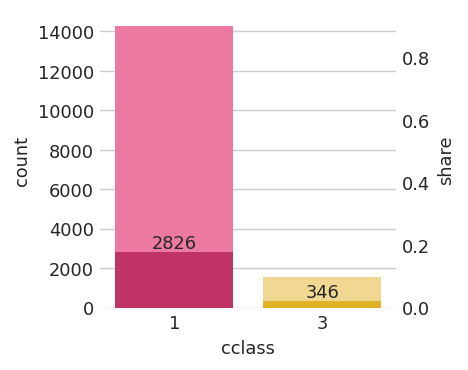

In [140]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.hd_sizes = plot_c_classes(hd_pairs)
fig.savefig(c.dp / 'hds_cclasses.svg')
fig.savefig(c.dp / 'hds_cclasses.png', dpi=300, transparent=False)

In [142]:
c.hd_sizes

{1: 2826, 3: 346}

In [146]:
with (c.dp / 'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "add_proteomes": true,
  "slurm": true,
  "slurm_node_limit": 15,
  "rostclust": "/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust",
  "cwd": "/home/k/kaindll/ppi/data/ppi_dataset/results/7082",
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "homodimers/proteomes",
  "ip": "apid_isp",
  "dp": "homodimers",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 4.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [],
  "train_species": [],
  "test_species": [
    9986,
    10116,
    83333,
    9606,
    10377,
    39947,
    284812,
    7955,
    1111708,
    8355,
    224308,
    9913,
    11706,
    10299,
    7227,
    559292,
    333760,
    9031,
    85962,
    243276,
    2697049,
    

In [ ]:
# cluster all proteins from APID *species with homodimers* against val
# carefully red-reduce the set
# cluster the nr_val proteomes against it
# rr each
# rr the combined set
# sample 1:1 or 1:2 ?

In [ ]:
# cluster all proteins from APID *species with homodimers* against val
# extract hd_fasta_nr_val
# carefully red-reduce: per species first? consider available proteins

# construct nohd_fasta_nr_val per species
# collate with nr_val proteomes
# cluster against hd_fasta_rr_val
# ********TRICKY: exclude IDs from hd_fasta? from  hd_fasta_nr_val?
# carefully red-reduce

# sample 1:1 or 1:2 ?